## One-Dimensional Steady Flow with Transport

MOC3D Problem 1



### One-Dimensional Steady Flow with Transport Problem Setup

Imports

In [1]:
import os
import sys

In [2]:
import flopy
import matplotlib.pyplot as plt
import numpy as np

Append to system path to include the common subdirectory

In [3]:
sys.path.append(os.path.join("..", "common"))

Import common functionality

In [4]:
import analytical
import config
from figspecs import USGSFigure

In [5]:
mf6exe = "mf6"
exe_name_mf = "mf2005"
exe_name_mt = "mt3dms"

Set figure properties specific to this problem

In [6]:
figure_size = (5, 3)

Base simulation and model name and workspace

In [7]:
ws = config.base_ws
example_name = "moc"

Scenario parameters - make sure there is at least one blank line before next item

In [8]:
parameters = {
    "ex-gwt-moc3d-p01a": {
        "longitudinal_dispersivity": 0.01,
        "retardation_factor": 1.0,
        "decay_rate": 0.0,
    },
    # "ex-gwt-moc3d-p01b": {
    #     "longitudinal_dispersivity": 1.0,
    #     "retardation_factor": 1.0,
    #     "decay_rate": 0.0,
    # },
    # "ex-gwt-moc3d-p01c": {
    #     "longitudinal_dispersivity": 1.0,
    #     "retardation_factor": 2.0,
    #     "decay_rate": 0.0,
    # },
    # "ex-gwt-moc3d-p01d": {
    #     "longitudinal_dispersivity": 1.0,
    #     "retardation_factor": 1.0,
    #     "decay_rate": 0.01,
    # },
}

Scenario parameter units - make sure there is at least one blank line before next item
add parameter_units to add units to the scenario parameter table

In [9]:
parameter_units = {
    "longitudinal_dispersivity": "$m$",
    "retardation_factor": "unitless",
    "decay_rate": "$s^{-1}$",
}

Model units

In [10]:
length_units = "m"
time_units = "seconds"

Table of model parameters

In [11]:
nper = 1  # Number of periods
nlay = 1  # Number of layers
nrow = 1  # Number of rows
ncol = 40  # Number of columns
system_length = .08  # Length of system ($m$)
delr = 0.002  # Column width ($m$)
delc = 1.0  # Row width ($m$)
top = 1.0  # Top of the model ($cm$)
botm = 0  # Layer bottom elevation ($cm$)
specific_discharge = .01  # Specific discharge ($m s^{-1}$)
hydraulic_conductivity = 1.0  # Hydraulic conductivity ($m s^{-1}$)
porosity = 1.0  # Porosity of mobile domain (unitless)
total_time = 14400.0  # Simulation time ($s$)
source_concentration = 1.0  # Source concentration (unitless)
initial_concentration = 0.0  # Initial concentration (unitless)

### Functions to build, write, run, and plot models

MODFLOW 6 flopy GWF simulation object (sim) is returned


In [12]:
def get_sorption_dict(retardation_factor):
    sorption = None
    bulk_density = None
    distcoef = None
    if retardation_factor > 1.0:
        sorption = "linear"
        bulk_density = 1.0
        distcoef = (retardation_factor - 1.0) * porosity / bulk_density
    sorption_dict = {
        "sorption": sorption,
        "bulk_density": bulk_density,
        "distcoef": distcoef,
    }
    return sorption_dict

In [13]:
def get_decay_dict(decay_rate, sorption=False):
    first_order_decay = None
    decay = None
    decay_sorbed = None
    if decay_rate != 0.0:
        first_order_decay = True
        decay = decay_rate
        if sorption:
            decay_sorbed = decay_rate
    decay_dict = {
        "first_order_decay": first_order_decay,
        "decay": decay,
        "decay_sorbed": decay_sorbed,
    }
    return decay_dict

In [14]:
def build_mf6gwf(sim_folder):
    print(f"Building mf6gwf model...{sim_folder}")
    name = "flow"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwf")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 1, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim)
    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_specific_discharge=True,
        save_saturation=True,
        icelltype=0,
        k=hydraulic_conductivity,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    wel_spd = {
        0: [
            [
                (0, 0, 0),
                specific_discharge * delc * delr * top,
                source_concentration,
            ]
        ],
    }
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        pname="WEL-1",
        auxiliary=["CONCENTRATION"],
    )
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )
    return sim

MODFLOW 6 flopy GWF simulation object (sim) is returned

In [15]:
def build_mf6gwt(sim_folder, longitudinal_dispersivity, retardation_factor, decay_rate):
    print(f"Building mf6gwt model...{sim_folder}")
    name = "trans"
    sim_ws = os.path.join(ws, sim_folder, "mf6gwt")
    sim = flopy.mf6.MFSimulation(
        sim_name=name, sim_ws=sim_ws, exe_name="mf6"
    )
    tdis_ds = ((total_time, 240, 1.0),)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(sim, linear_acceleration="bicgstab")
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(
        gwt,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwtic(gwt, strt=0)
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=porosity,
        **get_sorption_dict(retardation_factor),
        **get_decay_dict(decay_rate, retardation_factor > 1.0),
    )
    flopy.mf6.ModflowGwtadv(gwt, scheme="TVD")
    flopy.mf6.ModflowGwtdsp(
        gwt,
        xt3d_off=True,
        alh=longitudinal_dispersivity,
        ath1=longitudinal_dispersivity,
    )
    pd = [
        ("GWFHEAD", f"../mf6gwf/flow.hds", None),
        ("GWFBUDGET", "../mf6gwf/flow.bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)
    sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)
    # flopy.mf6.ModflowGwtcnc(gwt, stress_period_data=[((0, 0, 0), source_concentration),])
    obs_data = {
        f"{name}.obs.csv": [
            ("X001", "CONCENTRATION", (0, 0, 0)),
            ("X040", "CONCENTRATION", (0, 0, 20)),
            ("X079", "CONCENTRATION", (0, 0, 39)),
        ],
    }
    obs_package = flopy.mf6.ModflowUtlobs(
        gwt, digits=10, print_input=True, continuous=obs_data
    )
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{name}.cbc",
        concentration_filerecord=f"{name}.ucn",
        saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "LAST")],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    )
    return sim

In [16]:
def build_model(sim_name, longitudinal_dispersivity, retardation_factor, decay_rate):
    sims = None
    if config.buildModel:
        sim_mf6gwf = build_mf6gwf(sim_name)
        sim_mf6gwt = build_mf6gwt(
            sim_name, longitudinal_dispersivity, retardation_factor, decay_rate
        )
        sims = (sim_mf6gwf, sim_mf6gwt)
    return sims

Function to write model files

In [17]:
def write_model(sims, silent=True):
    print("in write_model")
    if config.writeModel:
        print("writeModel")
        sim_mf6gwf, sim_mf6gwt = sims
        sim_mf6gwf.write_simulation(silent=silent)
        sim_mf6gwt.write_simulation(silent=silent)
    return

Function to run the model
True is returned if the model runs successfully

In [18]:
@config.timeit
def run_model(sims, silent=True):
    success = True
    print("print1")
    if config.runModel:
        success = False
        sim_mf6gwf, sim_mf6gwt = sims
        success, buff = sim_mf6gwf.run_simulation(silent=silent)
        if not success:
            print("print2")
            print(buff)
        success, buff = sim_mf6gwt.run_simulation(silent=silent)
        if not success:
            print("print3")
            print(buff)
    return success

Function to plot the model results

In [19]:
def plot_results_ct(
    sims, idx, longitudinal_dispersivity, retardation_factor, decay_rate
):
    if config.plotModel:
        print("Plotting C versus t model results...")
        sim_mf6gwf, sim_mf6gwt = sims
        fs = USGSFigure(figure_type="graph", verbose=False)

        sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
        mf6gwt_ra = sim_mf6gwt.get_model("trans").obs.output.obs().data
        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        alabel = ["ANALYTICAL", "", ""]
        mlabel = ["MODFLOW 6", "", ""]
        iskip = 5
        atimes = np.arange(0, total_time, 0.1)
        obsnames = ["X001", "X040", "X079"]
        simtimes = mf6gwt_ra["totim"]
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )
        for i, x in enumerate([0.05, 4.05, 11.05]):
            a1 = analytical.Wexler1d().analytical2(
                x,
                atimes,
                specific_discharge / retardation_factor,
                system_length,
                dispersion_coefficient,
                decay_rate,
            )
            if idx == 0:
                idx_filter = a1 < 0
                a1[idx_filter] = 0
                idx_filter = a1 > 1
                a1[idx_filter] = 0
                idx_filter = atimes > 0
                if i == 2:
                    idx_filter = atimes > 79
            elif idx > 0:
                idx_filter = atimes > 0
            ##axs.plot(atimes[idx_filter], a1[idx_filter], color="k", label=alabel[i])
            axs.plot(
                simtimes[::iskip],
                mf6gwt_ra[obsnames[i]][::iskip],
                marker="o",
                ls="none",
                mec="blue",
                mfc="none",
                markersize="4",
                label=mlabel[i],
            )
        axs.set_ylim(0, 1.2)
        ##axs.set_xlim(0, 120)
        axs.set_xlim(0, 14400)
        axs.set_xlabel("Time (seconds)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        if idx in [0, 1]:
            axs.text(1, 0.5, "x=0.05")
            axs.text(20, 0.5, "x=4.05")
            axs.text(30, 0.5, "x=11.05")
        ##axs.legend()

        # save figure
        if config.plotSave:
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-ct{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

In [20]:
def plot_results_cd(
    sims, idx, longitudinal_dispersivity, retardation_factor, decay_rate
):
    print("XXX")
    if config.plotModel:
        print("Plotting C versus x model results...")
        sim_mf6gwf, sim_mf6gwt = sims
        fs = USGSFigure(figure_type="graph", verbose=False)

        ucnobj_mf6 = sim_mf6gwt.trans.output.concentration()

        fig, axs = plt.subplots(1, 1, figsize=figure_size, dpi=300, tight_layout=True)
        alabel = ["ANALYTICAL", "", ""]
        mlabel = ["MODFLOW 6", "", ""]
        iskip = 5
        ctimes = [60.0, 7200., 14400.]
        x = np.linspace(0.5 * delr, system_length - 0.5 * delr, ncol - 1)
        dispersion_coefficient = (
            longitudinal_dispersivity * specific_discharge / retardation_factor
        )

        for i, t in enumerate(ctimes):
            a1 = analytical.Wexler1d().analytical2(
                x,
                t,
                specific_discharge / retardation_factor,
                system_length,
                dispersion_coefficient,
                decay_rate,
            )
            if idx == 0:
                idx_filter = x > system_length
                if i == 0:
                    idx_filter = x > 6
                if i == 1:
                    idx_filter = x > 9
                a1[idx_filter] = 0.0
            ##axs.plot(x, a1, color="k", label=alabel[i])
            simconc = ucnobj_mf6.get_data(totim=t).flatten()
            axs.plot(
                x[::iskip],
                simconc[::iskip],
                marker="o",
                ls="none",
                mec="blue",
                mfc="none",
                markersize="4",
                label=mlabel[i],
            )
        axs.set_ylim(0, 1.1)
        axs.set_xlim(0, .08)
        if idx in [0, 1]:
            axs.text(0.0, 0.7, "t=60 s")
            axs.text(.040, 0.7, "t=7200 s")
            axs.text(.070, 0.7, "t=14400 s")
        axs.set_xlabel("Distance (cm)")
        axs.set_ylabel("Normalized Concentration (unitless)")
        ##plt.legend()

        # save figure
        if config.plotSave:
            sim_ws = sim_mf6gwt.simulation_data.mfpath.get_sim_path()
            sim_folder = os.path.split(sim_ws)[0]
            sim_folder = os.path.basename(sim_folder)
            fname = f"{sim_folder}-cd{config.figure_ext}"
            fpth = os.path.join(ws, "..", "figures", fname)
            fig.savefig(fpth)

Function that wraps all of the steps for each scenario

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.


In [21]:
def scenario(idx, silent=True):
    print("in scenario")
    print(config.work_dir)
    key = list(parameters.keys())[idx]
    print(f"key={key}")
    parameter_dict = parameters[key]
    sims = build_model(key, **parameter_dict)
    write_model(sims, silent=silent)
    success = run_model(sims, silent=silent)
    if success:
        plot_results_ct(sims, idx, **parameter_dict)
        plot_results_cd(sims, idx, **parameter_dict)

In [22]:
# nosetest - exclude block from this nosetest to the next nosetest
def test_01():
    scenario(0, silent=False)

In [23]:
def test_02():
    scenario(1, silent=False)

In [24]:
def test_03():
    scenario(2, silent=False)

In [25]:
def test_04():
    scenario(3, silent=False)

nosetest end

In [26]:
%matplotlib inline

in scenario
..\tables
key=ex-gwt-moc3d-p01a
Building mf6gwf model...ex-gwt-moc3d-p01a
Building mf6gwt model...ex-gwt-moc3d-p01a
in write_model
writeModel
print1
run_model  179.58 ms
Plotting C versus t model results...
XXX
Plotting C versus x model results...


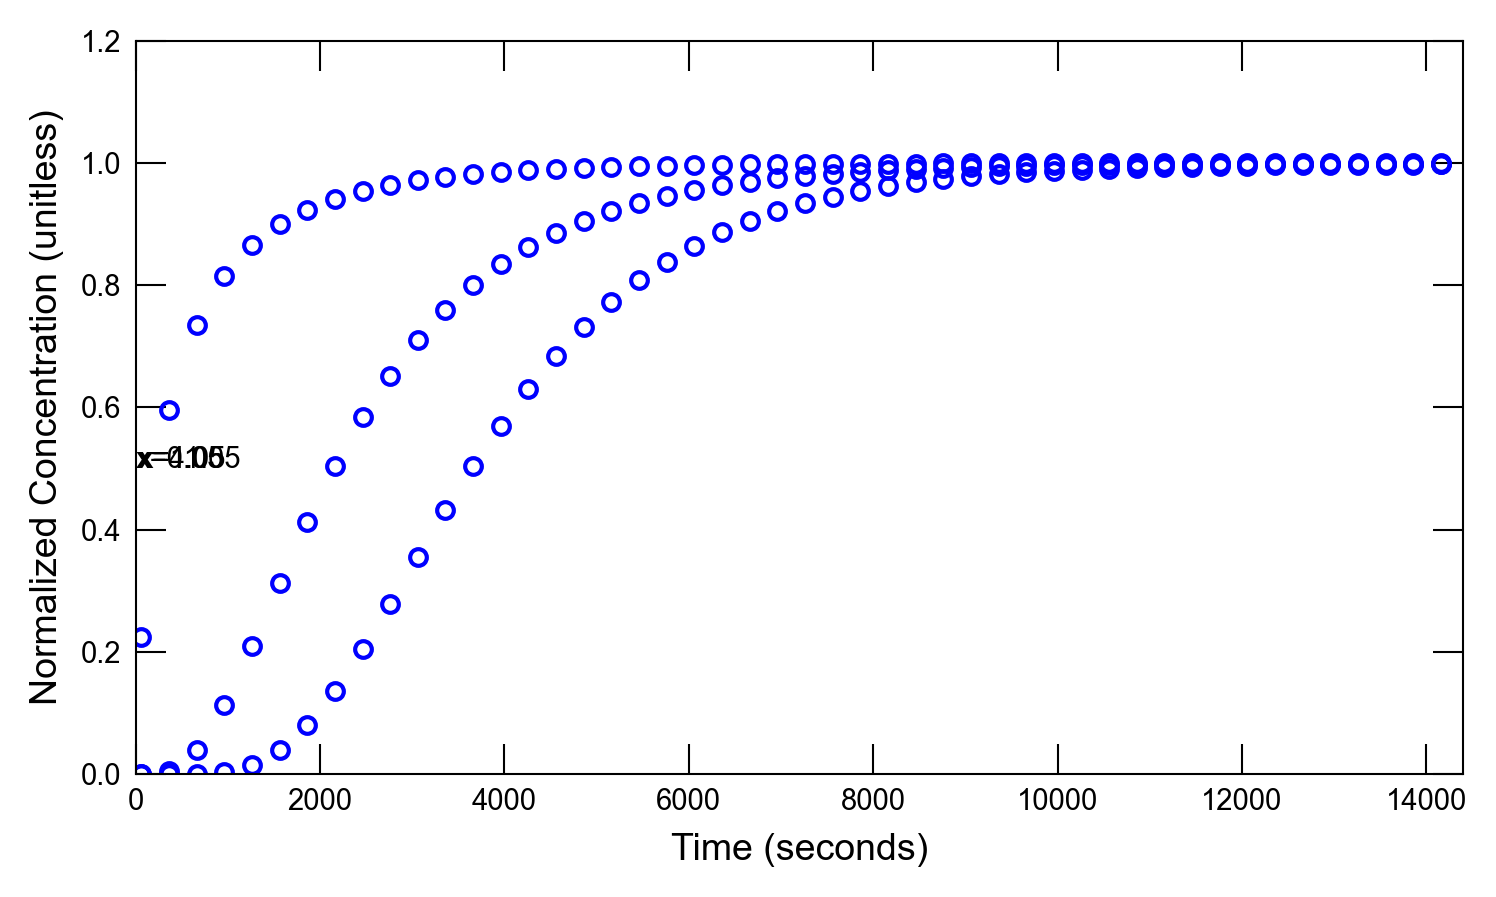

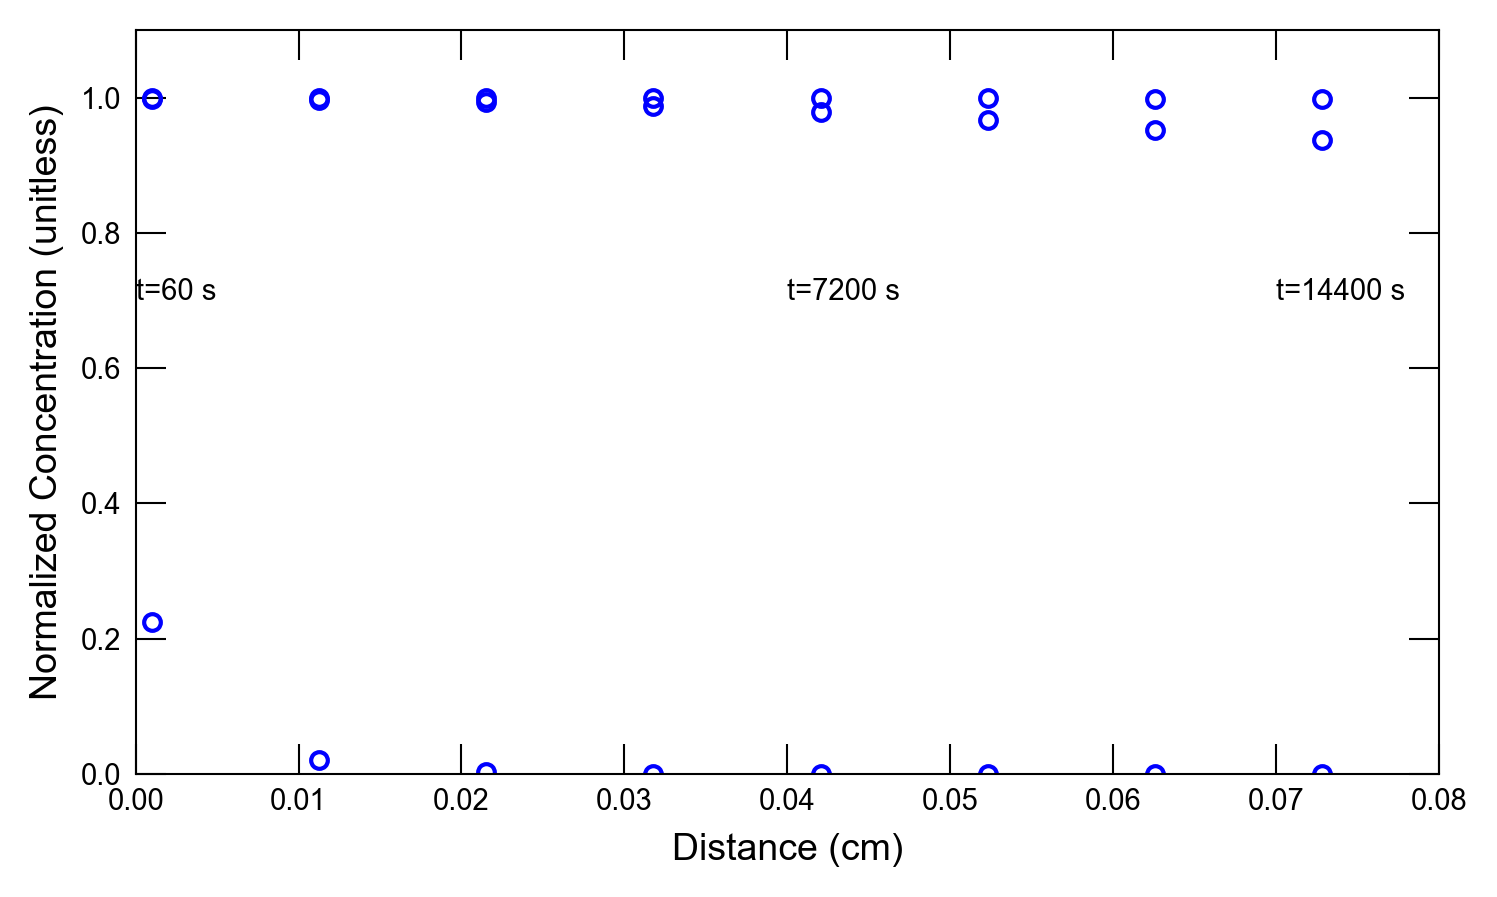

In [27]:
if __name__ == "__main__":
    # ### Simulated Zero-Order Growth in a Uniform Flow Field

    # Scenario 1 - description

    scenario(0)

    # Scenario 2 - description

    # scenario(1)

    # # Scenario 3 - description

    # scenario(2)

    # # Scenario 4 - description

    # scenario(3)